In [3]:
import cvxpy as cp
import numpy as np

def wheel_dynamics(current_state, control_input):
    """
    Placeholder for the actual dynamics function of the wheel.
    This should compute the next state given the current state and control input.
    """
    # For simplicity, assume a linear approximation (this could be a complex nonlinear function)
    A = np.array([[1, 0.1], [0, 1]])  # State transition matrix
    B = np.array([[0], [0.1]])  # Control input matrix
    next_state = A @ current_state + B @ control_input
    return next_state

def use_mpc_for_wheel_tracking(trajectory, N, Q, R, P, x0, umax=None, umin=None):
    """
    Solve MPC for wheel tracking a given trajectory.
    """
    nx = x0.shape[0]
    nu = 1  # Assuming a single control input (e.g., torque or steering)

    # Define optimization variables
    x = cp.Variable((nx, N + 1))
    u = cp.Variable((nu, N))

    cost = 0.0
    constraints = []

    # Set up the optimization problem
    for t in range(N):
        # Cost function: minimize the tracking error and control effort
        cost += 0.5 * cp.quad_form(x[:, t] - trajectory[:, t], Q)
        cost += 0.5 * cp.quad_form(u[:, t], R)

        # Apply the dynamics to get the next state (using the given nonlinear dynamics)
        next_state = wheel_dynamics(x[:, t], u[:, t])

        # System dynamics constraint
        constraints += [x[:, t + 1] == next_state]

        # Input constraints
        if umax is not None:
            constraints += [u[:, t] <= umax]
        if umin is not None:
            constraints += [u[:, t] >= umin]

    # Terminal cost to ensure we reach close to the final desired state
    cost += 0.5 * cp.quad_form(x[:, N] - trajectory[:, N], P)

    # Initial state constraint
    constraints += [x[:, 0] == x0.flatten()]

    # Solve the optimization problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(verbose=True)

    return x.value, u.value

In [7]:
# Desired trajectory (e.g., position and velocity over time)
N = 10  # Time horizon
trajectory = np.zeros((2, N + 1))  # Placeholder for the desired trajectory (2 states, N+1 time steps)
trajectory[0, :] = np.linspace(0, 10, N + 1)  # Example trajectory for position
trajectory[1, :] = np.linspace(0, 0, N + 1)  # Example trajectory for velocity (stay at 0)

# Initial state (e.g., starting at position 0, velocity 0)
x0 = np.array([[0], [0]])

# Weights for cost function
Q = np.eye(2)  # State cost
R = np.eye(1) * 0.1  # Input cost
P = np.eye(2)  # Terminal state cost

# Input constraints (e.g., maximum and minimum torque or steering)
umax = np.array([[1]])
umin = np.array([[-1]])

# Run the MPC solver
x_trajectory, u_trajectory = use_mpc_for_wheel_tracking(trajectory, N, Q, R, P, x0, umax, umin)

print("Optimal state trajectory:\n", x_trajectory)
print("Optimal control inputs:\n", u_trajectory)


                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 19 04:28:23 AM: Your problem has 32 variables, 42 constraints, and 0 parameters.
(CVXPY) Aug 19 04:28:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 19 04:28:23 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 19 04:28:23 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 19 04:28:23 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 19 04:28:23 AM: Compiling problem (target solver=OSQP).
(CV

In [8]:
import numpy as np
import pandas as pd
from tinyphysics import TinyPhysicsModel

# Initialize the model
model = TinyPhysicsModel('models/tinyphysics.onnx', debug=False)

# Define the ranges for the input parameters
v_ego_range = np.linspace(10, 30, 10)  # Velocity from 10 to 30 m/s
a_ego_range = np.linspace(-2, 2, 10)   # Acceleration from -2 to 2 m/s^2
roll_lataccel_range = np.linspace(-1, 1, 10)  # Roll lateral accel from -1 to 1 m/s^2
current_lataccel_range = np.linspace(-2, 2, 10)  # Current lataccel from -2 to 2 m/s^2
steer_action_range = np.linspace(-0.5, 0.5, 10)  # Steering action from -0.5 to 0.5 rad

# Create a DataFrame to store the inputs and outputs
data = pd.DataFrame(columns=['v_ego', 'a_ego', 'roll_lataccel', 'current_lataccel', 'steer_action', 'predicted_lataccel'])

# Iterate over combinations of inputs
for v_ego in v_ego_range:
    for a_ego in a_ego_range:
        for roll_lataccel in roll_lataccel_range:
            for current_lataccel in current_lataccel_range:
                for steer_action in steer_action_range:
                    # Prepare the input data for the model
                    state = {
                        'v_ego': v_ego,
                        'a_ego': a_ego,
                        'roll_lataccel': roll_lataccel,
                        'lataccel': current_lataccel
                    }
                    # Get the predicted lateral acceleration
                    predicted_lataccel = model.get_current_lataccel([state], [steer_action], [current_lataccel])

                    # Store the input-output pair
                    data = data.append({
                        'v_ego': v_ego,
                        'a_ego': a_ego,
                        'roll_lataccel': roll_lataccel,
                        'current_lataccel': current_lataccel,
                        'steer_action': steer_action,
                        'predicted_lataccel': predicted_lataccel
                    }, ignore_index=True)

# Save the collected data to a CSV file for further analysis
data.to_csv('bicycle_model_data.csv', index=False)


c:\Users\pmazu\Documents\GitHub\controls_challenge\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: could not convert string to float: 'v_ego'

In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the data generated from the ONNX model predictions
data = pd.read_csv('bicycle_model_data.csv')

# Define the bicycle model function (calculating lataccel)
def bicycle_model(params, v_ego, steer_action, roll_lataccel):
    C_f, C_r, l_f, l_r, m, I_z = params

    # Calculate lateral acceleration (v_y_dot) using the bicycle model
    v_y_dot = (- (C_f + C_r) / (m * v_ego)) * roll_lataccel \
              + ((C_r * l_r - C_f * l_f) / (m * v_ego)) * roll_lataccel \
              + (C_f / m) * steer_action

    return v_y_dot

# Define the objective function for optimization
def objective_function(params, data):
    # Predicted lateral acceleration using the bicycle model
    predicted_lataccel = bicycle_model(params, data['v_ego'], data['steer_action'], data['roll_lataccel'])

    # The difference between the bicycle model prediction and ONNX model prediction
    return np.sum((predicted_lataccel - data['predicted_lataccel'])**2)

# Initial guess for the parameters [C_f, C_r, l_f, l_r, m, I_z]
initial_guess = [20000, 20000, 1.2, 1.6, 1500, 2250]

# Perform optimization to find the best-fitting parameters
result = minimize(objective_function, initial_guess, args=(data,))

# Extract the fitted parameters
C_f, C_r, l_f, l_r, m, I_z = result.x

print("Fitted Parameters:")
print(f"C_f: {C_f}")
print(f"C_r: {C_r}")
print(f"l_f: {l_f}")
print(f"l_r: {l_r}")
print(f"m: {m}")
print(f"I_z: {I_z}")


Fitted Parameters:
C_f: 20007.774179020045
C_r: 20007.775478532465
l_f: 0.35154038175707447
l_r: 2.4254582697804947
m: 1292.6715739509436
I_z: 2250.0


c:\Users\pmazu\Documents\GitHub\controls_challenge\.conda\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [92]:
# different funky way of doing it

import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the data generated from the ONNX model predictions
data = pd.read_csv('bicycle_model_data.csv')

# Define the bicycle model function (calculating lataccel)
def bicycle_model_dynamics(params, v_ego, steer_angle, roll_lataccel):
    beta = 0
    yaw_rate = 0
    C_f, C_r, l_f, l_r, m, I_z= params
    # Lateral slip angles at the front and rear tires
    alpha_f = steer_angle - (beta + (l_f * yaw_rate) / v_ego)
    alpha_r = - (beta - (l_r * yaw_rate) / v_ego)

    # Lateral forces on the front and rear tires
    F_yf = -C_f * alpha_f
    F_yr = -C_r * alpha_r

    # Equations of motion
    a_lat = (F_yf + F_yr) / m  # Lateral acceleration
    yaw_accel = (l_f * F_yf - l_r * F_yr) / I_z  # Yaw acceleration

    return a_lat

# Define the objective function for optimization
def objective_function(params, data):
    # Predicted lateral acceleration using the bicycle model
    vehicle_lataccel  = bicycle_model(params, data['v_ego'], data['steer_action'], data['roll_lataccel'])
    predicted_lataccel = vehicle_lataccel - data['roll_lataccel']

    # The difference between the bicycle model prediction and ONNX model prediction
    return np.sum((predicted_lataccel - data['predicted_lataccel'])**2)

# Initial guess for the parameters [C_f, C_r, l_f, l_r, m, I_z]
initial_guess = [20000, 20000, 1.2, 1.6, 1500, 2250]

# Perform optimization to find the best-fitting parameters
result = minimize(objective_function, initial_guess, args=(data,))

# Extract the fitted parameters
C_f, C_r, l_f, l_r, m, I_z = result.x

print("Fitted Parameters:")
print(f"C_f: {C_f}")
print(f"C_r: {C_r}")
print(f"l_f: {l_f}")
print(f"l_r: {l_r}")
print(f"m: {m}")
print(f"I_z: {I_z}")


Fitted Parameters:
C_f: 20007.774179020045
C_r: 20007.775478532465
l_f: 0.35154038175707447
l_r: 2.4254582697804947
m: 1292.6715739509436
I_z: 2250.0


c:\Users\pmazu\Documents\GitHub\controls_challenge\.conda\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


       v_ego  steer_action  roll_lataccel  predicted_lataccel  \
0  33.660820      0.008723       0.422254            0.913978   
1  33.655200      0.008723       0.421873            0.953079   
2  33.645374      0.008723       0.415679            0.982405   
3  33.638457      0.008723       0.409486            0.933529   
4  33.640816      0.008723       0.401738            1.050831   

   bicycle_lataccel  lataccel_difference  
0          0.149371            -0.764607  
1          0.149361            -0.803718  
2          0.149154            -0.833250  
3          0.148947            -0.784582  
4          0.148682            -0.902149  


C:\Users\pmazu\AppData\Local\Temp\ipykernel_28212\2968574276.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  v_y_dot = (- (C_f + C_r) / (m * v_ego)) * roll_lataccel \
C:\Users\pmazu\AppData\Local\Temp\ipykernel_28212\2968574276.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  + ((C_r * l_r - C_f * l_f) / (m * v_ego)) * roll_lataccel \
C:\Users\pmazu\AppData\Local\Temp\ipykernel_28212\2968574276.py:17: RuntimeWarning: invalid value encountered in scalar add
  v_y_dot = (- (C_f + C_r) / (m * v_ego)) * roll_lataccel \


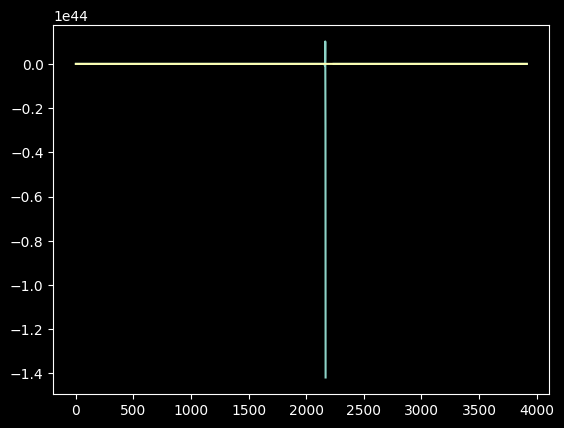

In [94]:
# compare 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original parameters obtained from your optimization
C_f = 20007.774179020045
C_r = 20007.775478532465
l_f = 0.35154038175707447
l_r = 2.4254582697804947
m = 1292.6715739509436
I_z = 2250

# Define the bicycle model dynamics
def bicycle_model_dynamics(v_ego, steer_action, roll_lataccel):
    # Calculate lateral forces
    v_y_dot = (- (C_f + C_r) / (m * v_ego)) * roll_lataccel \
              + ((C_r * l_r - C_f * l_f) / (m * v_ego)) * roll_lataccel \
              + (C_f / m) * steer_action
    # F_yf = -C_f * (roll_lataccel + (l_f * roll_lataccel) / v_ego - steer_action)
    # F_yr = -C_r * (roll_lataccel - (l_r * roll_lataccel) / v_ego)

    # # Calculate lateral acceleration
    # a_lat = (F_yf + F_yr) / m
    return v_y_dot

# Load the data generated from the ONNX model predictions
data = pd.read_csv('bicycle_model_data.csv')

# Calculate the lateral acceleration for each data point using the bicycle model
data['bicycle_lataccel'] = data.apply(lambda row: bicycle_model_dynamics(row['v_ego'], row['steer_action'], row['roll_lataccel']), axis=1)
plt.plot(data['bicycle_lataccel'])
plt.plot(data['predicted_lataccel'])

# Compare with the ONNX model predictions
data['lataccel_difference'] = data['bicycle_lataccel'] - data['predicted_lataccel']

# Print the first few rows to inspect the differences
print(data[['v_ego', 'steer_action', 'roll_lataccel', 'predicted_lataccel', 'bicycle_lataccel', 'lataccel_difference']].head())

In [71]:
import numpy as np
import pandas as pd

# Constants
g = 9.81  # gravitational acceleration, m/s²
L = 0.35 + 2.43  # wheelbase in meters, calculated from l_f + l_r
K_US = -0.027  # example value for understeer coefficient, this should be fitted or given

# Load the data
data = pd.read_csv('bicycle_model_data.csv')

# Function to calculate lateral acceleration using the new formula
def calculate_lateral_accel(v_ego, steer_action, K_US, L):
    G_acc = (v_ego**2 / (g * L)) + (v_ego**2 * K_US)
    a_y = G_acc * g * steer_action
    return a_y

# Apply the new calculation to the data
data['new_bicycle_lataccel'] = data.apply(
    lambda row: calculate_lateral_accel(row['v_ego'], row['steer_action'], K_US, L), axis=1
)

# Compare with predicted_lataccel
data['new_lataccel_difference'] = data['new_bicycle_lataccel'] - data['predicted_lataccel']

# Display the differences to see if the error is reduced
print(data[['v_ego', 'steer_action', 'new_bicycle_lataccel', 'predicted_lataccel', 'new_lataccel_difference']])


          v_ego  steer_action  new_bicycle_lataccel  predicted_lataccel  \
0     33.660820      0.008723              0.937426            0.913978   
1     33.655200      0.008723              0.937113            0.953079   
2     33.645374      0.008723              0.936566            0.982405   
3     33.638457      0.008723              0.936181            0.933529   
4     33.640816      0.008723              0.936312            1.050831   
...         ...           ...                   ...                 ...   
3911  12.329711     -0.002016             -0.029072            0.738025   
3912  12.358790     -0.002016             -0.029209            0.747801   
3913  12.384296     -0.002016             -0.029330            2.448680   
3914  12.382534     -0.002016             -0.029321           -0.307918   
3915  12.397925     -0.002016             -0.029394            1.559140   

      new_lataccel_difference  
0                    0.023448  
1                   -0.015966  
2  

In [43]:
# find where huge
large = data['bicycle_lataccel'] > 1
data[large]

,v_ego,a_ego,roll_lataccel,current_lataccel,steer_action,predicted_lataccel,bicycle_lataccel,lataccel_difference
1609,3.227055e-01,-1.020646e+00,0.294520,0.014663,0.000102,0.043988,1.131663e+00,1.087674e+00
1610,2.613691e-01,-7.536668e-01,0.294520,-0.004888,0.000102,0.004888,1.396865e+00,1.391978e+00
1611,2.165456e-01,-5.614455e-01,0.294520,-0.004888,0.000102,0.014663,1.685681e+00,1.671019e+00
1612,1.185065e-01,-9.478053e-01,0.294520,0.004888,0.000102,-0.004888,3.078926e+00,3.083813e+00
1616,3.646667e-03,9.717636e-02,0.294520,0.004888,0.000102,0.004888,1.000070e+02,1.000021e+02
...,...,...,...,...,...,...,...,...
2158,1.587863e-41,1.253294e-40,0.172871,0.004888,0.011447,0.004888,1.348073e+40,1.348073e+40
2159,2.941611e-42,-3.230468e-41,0.172871,0.004888,0.011447,0.004888,7.276812e+40,7.276812e+40
2163,1.162853e-43,2.787987e-42,0.172871,0.004888,0.011447,0.004888,1.840779e+42,1.840779e+42
2164,9.371832e-44,7.951683e-43,0.172871,0.004888,0.011447,0.004888,2.284031e+42,2.284031e+42


In [2]:
import numpy as np

class BicycleModel:
    def __init__(self, mass, cp):
        """
        Initialize the BicycleModel with mass and characteristic length (cp).
        
        Parameters:
        - mass: Mass of the vehicle (kg)
        - cp: Characteristic length (m)
        """
        self.mass = mass
        self.cp = cp
    
    def update_position(self, x, y, v_ego, yaw, dt):
        x_new = x + v_ego * np.cos(yaw) * dt
        y_new = y + v_ego * np.sin(yaw) * dt
        return x_new, y_new

    def update_yaw(self, yaw, yaw_rate, dt):
        yaw_new = yaw + yaw_rate * dt
        return yaw_new

    def lateral_force(self, steer_angle, velocity):
        # Calculate the lateral force based on steer angle, velocity, and mass
        return self.mass * velocity**2 * np.tan(steer_angle) / self.cp

    def steering_dynamics(self, steer_angle, velocity):
        # Calculate the yaw rate from the steer angle and velocity
        yaw_rate = velocity * np.tan(steer_angle) / self.cp
        return yaw_rate

    def lateral_dynamics(self, lateral_force, velocity):
        # Calculate lateral acceleration
        lat_accel = lateral_force / self.mass
        # Consider road roll and other effects
        roll_effect = velocity * lat_accel / self.cp
        return lat_accel + roll_effect

    def longitudinal_dynamics(self, throttle_input, brake_input):
        # Calculate the resultant acceleration based on throttle and brake inputs
        accel = throttle_input - brake_input / self.mass
        return accel

    def step(self, state, inputs, dt):
        """
        Advance the model by one time step.
        
        Parameters:
        - state: [x, y, yaw, v_ego] (current state of the vehicle)
        - inputs: [steer_angle, throttle_input, brake_input] (driver inputs)
        - dt: Time step (s)
        
        Returns:
        - new_state: [x_new, y_new, yaw_new, v_ego_new] (updated state)
        - lat_accel: Lateral acceleration (m/s^2)
        """
        x, y, yaw, v_ego = state
        steer_angle, throttle_input, brake_input = inputs

        # Update position and orientation
        yaw_rate = self.steering_dynamics(steer_angle, v_ego)
        yaw_new = self.update_yaw(yaw, yaw_rate, dt)
        x_new, y_new = self.update_position(x, y, v_ego, yaw, dt)
        
        # Compute forces and dynamics
        lat_force = self.lateral_force(steer_angle, v_ego)
        lat_accel = self.lateral_dynamics(lat_force, v_ego)
        accel = self.longitudinal_dynamics(throttle_input, brake_input)
        
        # Update velocity based on longitudinal acceleration
        v_ego_new = v_ego + accel * dt

        # Return the new state
        return [x_new, y_new, yaw_new, v_ego_new], lat_accel

# Sample inputs and testing the model
if __name__ == "__main__":
    # Initialize the model with sample mass and characteristic length (cp)
    mass = 1500  # kg
    cp = 2.5  # m
    model = BicycleModel(mass, cp)

    # Define initial state and inputs
    initial_state = [0.0, 0.0, 0.0, 10.0]  # [x, y, yaw, v_ego] (m, m, rad, m/s)
    inputs = [0.05, 500, 0]  # [steer_angle (rad), throttle_input (N), brake_input (N)]
    dt = 0.1  # time step (s)

    # Run the model for a few steps and print the results
    state = initial_state
    for _ in range(10):
        state, lat_accel = model.step(state, inputs, dt)
        print(f"State: {state}, Lateral Acceleration: {lat_accel:.2f} m/s^2")


State: [1.0, 0.0, 0.02001668335021552, 60.0], Lateral Acceleration: 10.01 m/s^2
State: [6.998798037296069, 0.12009208022523508, 0.14011678345150863, 110.0], Lateral Acceleration: 1801.50 m/s^2
State: [17.89099466176615, 1.6563383801012124, 0.36030030030387933, 160.0], Lateral Acceleration: 10899.08 m/s^2
State: [32.86365055649429, 7.297222659898379, 0.6805672339073277, 210.0], Lateral Acceleration: 33307.76 m/s^2
State: [49.185184896495926, 20.511136417303774, 1.1009175842618535, 260.0], Lateral Acceleration: 75032.54 m/s^2
State: [60.95741738767377, 43.69333955189943, 1.6213513513674571, 310.0], Lateral Acceleration: 142078.42 m/s^2
State: [59.39087912077858, 74.65373292566574, 2.241868535224138, 360.0], Lateral Acceleration: 240450.41 m/s^2
State: [37.00514131644417, 102.84732693131875, 2.9624691358318964, 410.0], Lateral Acceleration: 376153.51 m/s^2
State: [-3.3388681588699143, 110.15218144429625, 3.7831531531907325, 460.0], Lateral Acceleration: 555192.74 m/s^2
State: [-40.1923596

In [4]:
import casadi as ca
from collections import namedtuple

class BicycleModel:
    def __init__(self):
        # Fitted parameters from the onnx model
        self.C_f = 20007.77  # Front cornering stiffness
        self.C_r = 20007.78  # Rear cornering stiffness
        self.l_f = 0.35      # Distance from CG to front axle (in meters)
        self.l_r = 2.43      # Distance from CG to rear axle (in meters)
        self.m = 1292.67     # Vehicle mass (in kg)
        self.I_z = 2250.0    # Yaw moment of inertia (in kg*m^2)
    BicycleState = namedtuple('BicycleState', ['v_ego', 'yaw_rate', 'beta'])
    def dynamics(self, state, steer_angle):
        # Unpack the state variables
        v_ego, yaw_rate, beta = state
        
        # Bicycle model dynamics
        F_yf = -self.C_f * (beta + (self.l_f * yaw_rate) / v_ego - steer_angle)
        F_yr = -self.C_r * (beta - (self.l_r * yaw_rate) / v_ego)

        dv_ego = 0  # Assuming constant longitudinal speed
        dyaw_rate = (self.l_f * F_yf - self.l_r * F_yr) / self.I_z
        dbeta = (F_yf + F_yr) / (self.m * v_ego) - yaw_rate

        return ca.vertcat(dv_ego, dyaw_rate, dbeta)

    def cost_function(self, state, steer_angle, desired_yaw_rate):
        # Simple cost function to minimize deviation from desired yaw rate
        _, yaw_rate, _ = state
        cost = ca.norm_2(yaw_rate - desired_yaw_rate) ** 2
        return cost

# Instantiate the bicycle model
bicycle_model = BicycleModel()


In [13]:
import casadi as ca
from collections import namedtuple

# Define the namedtuples
State = namedtuple('State', ['roll_lataccel', 'v_ego', 'a_ego'])
FuturePlan = namedtuple('FuturePlan', ['lataccel', 'roll_lataccel', 'v_ego', 'a_ego'])

# Define the BicycleModel class
class BicycleModel:
    def __init__(self):
        # Fitted parameters from onnx model
        self.C_f = 20007.77  # Front cornering stiffness
        self.C_r = 20007.78  # Rear cornering stiffness
        self.l_f = 0.35      # Distance from CG to front axle
        self.l_r = 2.43      # Distance from CG to rear axle
        self.m = 1292.67     # Vehicle mass
        self.I_z = 2250.0    # Yaw moment of inertia

    def dynamics(self, state, steer_angle):
        # Calculate lateral acceleration
        beta = (self.C_f * self.l_f - self.C_r * self.l_r) / (self.m * state.v_ego ** 2) * steer_angle
        a_lat = (self.C_f + self.C_r) / self.m * beta
        return a_lat

    def cost_function(self, steer_angle, desired_lat_accel, state):
        # Calculate the lateral acceleration using the dynamics model
        a_lat = self.dynamics(state, steer_angle)
        # Cost is the squared difference between achieved and desired lateral acceleration
        return (a_lat - desired_lat_accel) ** 2

# Create an instance of the bicycle model
bicycle_model = BicycleModel()

# Define the initial state and desired lateral acceleration
initial_state = State(roll_lataccel=0.1, v_ego=15.0, a_ego=0.0)
desired_lat_accel = 2.0  # Desired lateral acceleration in m/s^2

# Optimization variable (steering angle)
steer_angle = ca.SX.sym('steer_angle')

# Define the cost function
cost = bicycle_model.cost_function(steer_angle, desired_lat_accel, initial_state)

# Set up the optimization problem
nlp = {'x': steer_angle, 'f': cost}

# Create the NLP solver
solver = ca.nlpsol('solver', 'ipopt', nlp)

# Set the bounds and initial guess for the optimization
lb = -ca.pi / 4  # minimum steering angle (-45 degrees)
ub = ca.pi / 4   # maximum steering angle (45 degrees)
initial_guess = 0.0

# Solve the optimization problem
solution = solver(x0=initial_guess, lbx=lb, ubx=ub)
optimal_steering = solution['x'].full().item()
print(f'Optimal Steering Angle: {optimal_steering:.4f} radians')

# Now you can compute the resulting state using this optimal steering angle
final_lat_accel = bicycle_model.dynamics(initial_state, optimal_steering)
print(f'Final Lateral Acceleration: {final_lat_accel:.4f} m/s^2')


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0000000e+00 0.00e+00 1.77e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [14]:
import casadi as ca
from collections import namedtuple

# Define the namedtuples
State = namedtuple('State', ['roll_lataccel', 'v_ego', 'a_ego'])
FuturePlan = namedtuple('FuturePlan', ['lataccel', 'roll_lataccel', 'v_ego', 'a_ego'])

# Define the BicycleModel class
class BicycleModel:
    def __init__(self):
        # Fitted parameters from onnx model
        self.C_f = 20007.77  # Front cornering stiffness
        self.C_r = 20007.78  # Rear cornering stiffness
        self.l_f = 0.35      # Distance from CG to front axle
        self.l_r = 2.43      # Distance from CG to rear axle
        self.m = 1292.67     # Vehicle mass
        self.I_z = 2250.0    # Yaw moment of inertia

    def dynamics(self, state, steer_angle):
        # Calculate lateral acceleration
        beta = (self.C_f * self.l_f - self.C_r * self.l_r) / (self.m * state.v_ego ** 2) * steer_angle
        a_lat = (self.C_f + self.C_r) / self.m * beta
        return a_lat

    def cost_function(self, steer_angle, desired_lat_accel, state, future_plan):
        # Calculate the current lateral acceleration using the dynamics model
        current_lat_accel = self.dynamics(state, steer_angle)
        
        # Calculate the lateral acceleration error
        lat_accel_error = current_lat_accel - desired_lat_accel
        
        # Calculate the jerk (change in acceleration)
        if future_plan.lataccel:
            jerk = current_lat_accel - future_plan.lataccel[0]
        else:
            jerk = 0.0
        
        # Define the cost as a weighted sum of lateral acceleration error and jerk
        cost = 50 * lat_accel_error ** 2 + jerk ** 2
        return cost

# Create an instance of the bicycle model
bicycle_model = BicycleModel()

# Define the initial state and desired lateral acceleration
initial_state = State(roll_lataccel=0.1, v_ego=15.0, a_ego=0.0)
desired_lat_accel = 2.0  # Desired lateral acceleration in m/s^2

# Define a simple future plan (for illustration purposes)
future_plan = FuturePlan(
    lataccel=[1.5, 1.6, 1.7],
    roll_lataccel=[0.2, 0.3, 0.4],
    v_ego=[15.0, 14.8, 14.6],
    a_ego=[0.1, 0.2, 0.3]
)

# Optimization variable (steering angle)
steer_angle = ca.SX.sym('steer_angle')

# Define the cost function with the original criteria
cost = bicycle_model.cost_function(steer_angle, desired_lat_accel, initial_state, future_plan)

# Set up the optimization problem
nlp = {'x': steer_angle, 'f': cost}

# Create the NLP solver
solver = ca.nlpsol('solver', 'ipopt', nlp)

# Set the bounds and initial guess for the optimization
lb = -ca.pi / 4  # minimum steering angle (-45 degrees)
ub = ca.pi / 4   # maximum steering angle (45 degrees)
initial_guess = 0.0

# Solve the optimization problem
solution = solver(x0=initial_guess, lbx=lb, ubx=ub)
optimal_steering = solution['x'].full().item()
print(f'Optimal Steering Angle: {optimal_steering:.4f} radians')

# Now you can compute the resulting state using this optimal steering angle
final_lat_accel = bicycle_model.dynamics(initial_state, optimal_steering)
print(f'Final Lateral Acceleration: {final_lat_accel:.4f} m/s^2')


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0225000e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 